In [2]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 122.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.1 MB/s eta 0:00:00


In [ ]:
!pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement mlxtend (from versions: none)
ERROR: No matching distribution found for mlxtend


In [2]:
import tensorflow
import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
# from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, classification_report, precision_score, recall_score, f1_score


In [8]:
dataset = "/content/drive/MyDrive/AD_Kaggle/AD_Kaggle"

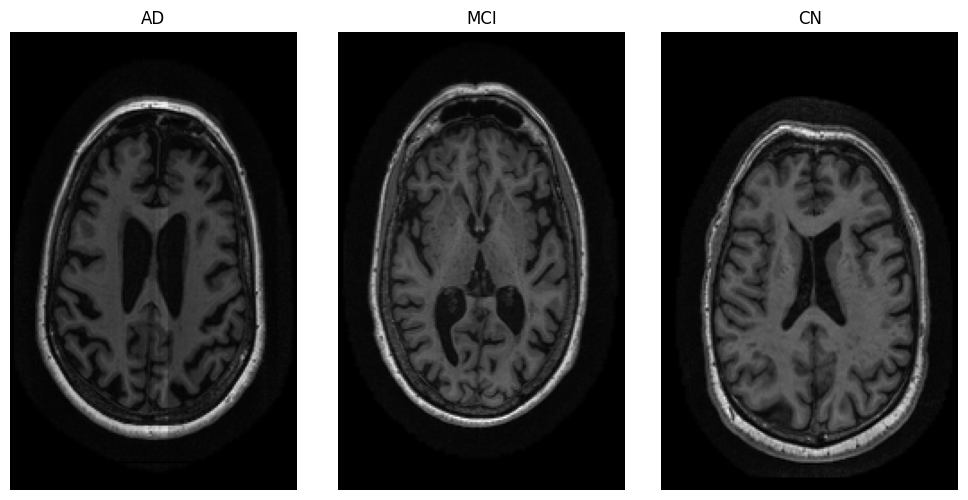

In [9]:
# Plot sample images
classes = ['AD', 'MCI', 'CN']
plt.figure(figsize=(10, 5))
for i, cls in enumerate(classes):
    class_path = os.path.join(dataset, cls)
    image_name = os.listdir(class_path)[0]
    image_path = os.path.join(class_path, image_name)
    image = plt.imread(image_path)
    plt.subplot(1, 3, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(cls)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
# Data Augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='constant'
)
data = data_gen.flow_from_directory(
    dataset,
    batch_size=32,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

Found 5154 images belonging to 3 classes.


In [ ]:
# # Get a batch of augmented images and labels
# images, labels = next(data)

# # Get class labels from the generator
# class_labels = list(data.class_indices.keys())

# # Find samples for each class
# samples_per_class = {}
# for img, label in zip(images, labels):
#     class_idx = np.argmax(label)
#     class_name = class_labels[class_idx]
#     if class_name not in samples_per_class:
#         samples_per_class[class_name] = img
#     if len(samples_per_class) == len(class_labels):
#         break

# # Plot one sample from each class
# plt.figure(figsize=(12, 6))
# for idx, (class_name, img) in enumerate(samples_per_class.items()):
#     plt.subplot(1, len(class_labels), idx+1)
#     plt.imshow(img)
#     plt.title(class_name)
#     plt.axis('off')

# plt.tight_layout()
# plt.show()

In [11]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
x = base_model.output
x = Flatten()(x)
model = Model(inputs=base_model.input, outputs=x)


In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
num_batches = 50

In [15]:
all_features = []
all_labels = []

In [17]:
for i in range(num_batches):
    images, labels = next(data)
    batch_features = model.predict(images)

    all_features.append(batch_features)
    all_labels.append(labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 

In [18]:
all_features = np.vstack(all_features)
all_labels = np.vstack(all_labels)

In [19]:
print("All features shape:", all_features.shape) # shape (num_samples, feature_size)
print("All labels shape:", all_labels.shape) # shape (num_samples, num_classes)

All features shape: (1632, 100352)
All labels shape: (1632, 3)


In [20]:
# Decode labels since they are one-hot encoded
decoded_labels = np.argmax(all_labels, axis=1)

# Combine features and labels
combined = np.hstack((all_features, decoded_labels.reshape(-1, 1)))

# Create a DataFrame
df = pd.DataFrame(combined)

# Save to CSV
df.to_csv('features_and_labels_without_augmentation.csv', index=False)

In [21]:
df

,0,1,2,3,4,5,6,7,8,9,...,100343,100344,100345,100346,100347,100348,100349,100350,100351,100352
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.780849,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.028870,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.897952,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.666661,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.410594,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.346818,0.0,0.0,2.0
1628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.941223,0.0,0.0,0.0
1629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.862790,0.0,0.0,2.0
1630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.442727,0.0,0.0,2.0


In [ ]:
df = pd.read_csv(r"C:\Users\jainashi\Downloads\features_and_labels_without_augmentation.csv\features_and_labels_without_augmentation.csv")

In [10]:
df

,0,1,2,3,4,5,6,7,8,9,...,100343,100344,100345,100346,100347,100348,100349,100350,100351,100352
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.780849,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.028870,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.897952,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.666661,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.410594,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.346818,0.0,0.0,2.0
1628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.941223,0.0,0.0,0.0
1629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.862790,0.0,0.0,2.0
1630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.442727,0.0,0.0,2.0


In [ ]:
# Separate features and labels
X = df.iloc[:, :-1].values  # all columns except the last
y = df.iloc[:, -1].astype(int).values  # last column as integer labels

In [ ]:
# 20 % training dataset is considered for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
KNC = KNeighborsClassifier()   # initialising KNeighbors Classifier
NB = GaussianNB()              # initialising Naive Bayes
LR = LogisticRegression()
SVM = SVC(kernel='linear', probability=True)
RF = RandomForestClassifier(n_estimators=100, random_state=42)


In [ ]:
model_kNeighborsClassifier = KNC.fit(X_train, y_train)   # fitting Training Set
pred_knc = model_kNeighborsClassifier.predict(X_test)   # Predicting on test dataset

In [ ]:
acc_knc = accuracy_score(y_test, pred_knc)  # evaluating accuracy score
print('accuracy score of KNeighbors Classifier is:', acc_knc * 100)

accuracy score of KNeighbors Classifier is: 93.57798165137615


In [ ]:
model_NaiveBayes = NB.fit(X_train, y_train)
pred_nb = model_NaiveBayes.predict(X_test)

In [ ]:
acc_nb = accuracy_score(y_test, pred_nb)
print('Accuracy of Naive Bayes Classifier:', acc_nb * 100)

Accuracy of Naive Bayes Classifier: 62.99694189602446


In [ ]:
model_LRClassifier = LR.fit(X_train, y_train)   # fitting Training Set
pred_lr = model_LRClassifier.predict(X_test)

c:\Users\jainashi\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
acc_lr = accuracy_score(y_test, pred_lr)  # evaluating accuracy score
print('accuracy score of Logistic Regression Classifier is:', acc_lr * 100)

accuracy score of Logistic Regression Classifier is: 70.9480122324159


In [ ]:
model_SVMClassifier = SVM.fit(X_train, y_train)   # fitting Training Set
pred_svm = model_SVMClassifier.predict(X_test)

In [ ]:
acc_svm = accuracy_score(y_test, pred_lr)  # evaluating accuracy score
print('accuracy score of Support Vector Machine Classifier is:', acc_svm * 100)

accuracy score of Support Vector Machine Classifier is: 70.9480122324159


In [ ]:
model_RFClassifier = RF.fit(X_train, y_train)   # fitting Training Set
pred_rf = model_RFClassifier.predict(X_test)

In [ ]:
acc_rf = accuracy_score(y_test, pred_rf)  # evaluating accuracy score
print('accuracy score of Random Forest Classifier is:', acc_rf * 100)

accuracy score of Random Forest Classifier is: 89.90825688073394


In [ ]:
# Meta-classifier
# meta_clf = LogisticRegression()
# meta_clf = RandomForestClassifier(n_estimators=100, random_state=42)
from xgboost import XGBClassifier

meta_classifier = XGBClassifier(n_estimators=100, learning_rate=0.1)

# Stacking classifier
stack = StackingClassifier(classifiers=[KNC, NB, SVM, LR, RF], meta_classifier=meta_classifier)

# Train
stack.fit(X_train, y_train)

# Predict
y_pred = stack.predict(X_test)

c:\Users\jainashi\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
acc_stack = accuracy_score(y_test, y_pred)  # evaluating accuracy
print('accuracy score of Stacked model:', acc_stack * 100)

accuracy score of Stacked model: 95.10703363914374


In [40]:
import seaborn as sns

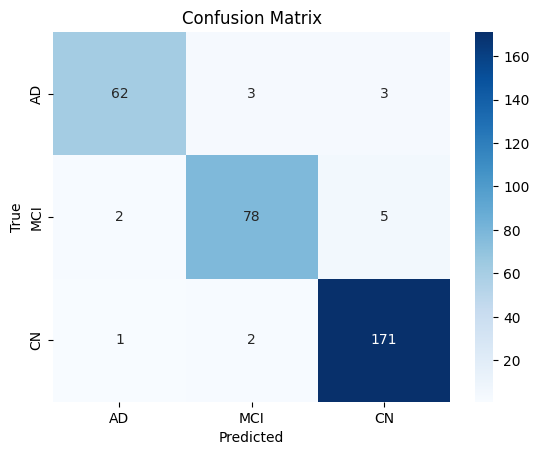

In [66]:
# Confusion matrix
classes = ['AD', 'MCI', 'CN']
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

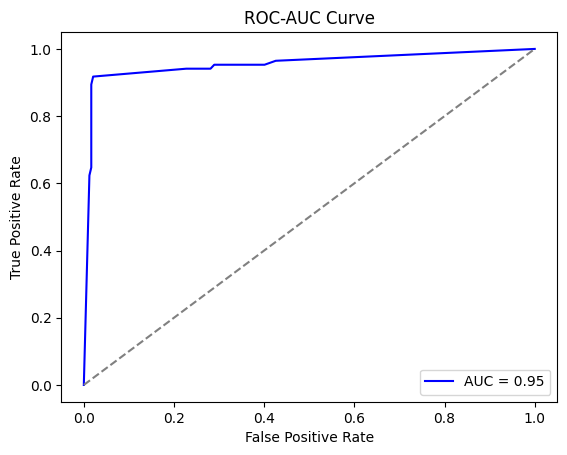

In [67]:
# ROC-AUC curve
probs = stack.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, probs[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC-AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [68]:
precision = precision_score(y_test, y_pred, average='weighted')  # or 'micro', 'macro'
print("Precision:", precision)

Precision: 0.9509618355381604


In [69]:
# Calculate recall (sensitivity)
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall (Sensitivity):", recall)

Recall (Sensitivity): 0.9510703363914373


In [70]:
# Calculate F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-Score:", f1)

F1-Score: 0.95077972890487


In [74]:
print(f"Test Accuracy: {acc_stack * 100:.2f}%")
print(f"Precision: {precision* 100:.2f}%")
print(f"Recall (Sensitivity): {recall* 100:.2f}%")
print(f"F1-Score: {f1* 100:.2f}%")

Test Accuracy: 95.11%
Precision: 95.10%
Recall (Sensitivity): 95.11%
F1-Score: 95.08%
